# Semi-Monocoque Theory: corrective solutions

In [1]:
from pint import UnitRegistry
import sympy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline
from IPython.display import display

Import **Section** class, which contains all calculations

In [2]:
from Section import Section

Initialization of **sympy** symbolic tool and **pint** for dimension analysis (not really implemented rn as not directly compatible with sympy)

In [3]:
ureg = UnitRegistry()
sympy.init_printing()

Define **sympy** parameters used for geometric description of sections

In [4]:
A, A0, t, t0, a, b, h, L, E, G = sympy.symbols('A A_0 t t_0 a b h L E G', positive=True)

We also define numerical values for each **symbol** in order to plot scaled section and perform calculations

In [5]:
values = [(A, 150 * ureg.millimeter**2),(A0, 250  * ureg.millimeter**2),(a, 80 * ureg.millimeter), \
          (b, 20 * ureg.millimeter),(h, 35 * ureg.millimeter),(L, 2000 * ureg.millimeter), \
          (t, 0.8 *ureg.millimeter),(E, 72e3 * ureg.MPa), (G, 27e3 * ureg.MPa)]
datav = [(v[0],v[1].magnitude) for v in values]

# First example: Simple rectangular symmetric section

Define graph describing the section:

1) **stringers** are **nodes** with parameters:
- **x** coordinate
- **y** coordinate
- **Area**

2) **panels** are **oriented edges** with parameters:
- **thickness**
- **lenght** which is automatically calculated

In [6]:
stringers = {1:[(2*a,h),A],
             2:[(a,h),A],
             3:[(sympy.Integer(0),h),A],
             4:[(sympy.Integer(0),sympy.Integer(0)),A],
             5:[(2*a,sympy.Integer(0)),A]}
             #5:[(sympy.Rational(1,2)*a,h),A]}

panels = {(1,2):t,
          (2,3):t,
          (3,4):t,
          (4,5):t,
          (5,1):t}

Define section and perform first calculations

In [7]:
S1 = Section(stringers, panels)

In [8]:
S1.cycles

## Plot of **S1** section in original reference frame

Define a dictionary of coordinates used by **Networkx** to plot section as a Directed graph.
Note that arrows are actually just thicker stubs

In [9]:
start_pos={ii: [float(S1.g.node[ii]['ip'][i].subs(datav)) for i in range(2)] for ii in S1.g.nodes() }

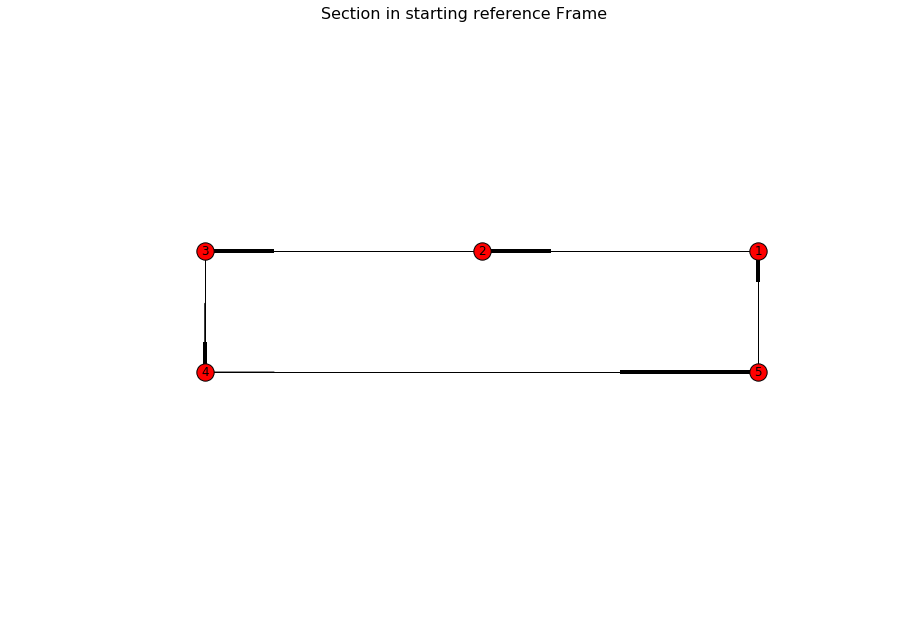

In [10]:
plt.figure(figsize=(12,8),dpi=300)
nx.draw(S1.g,with_labels=True, arrows= True, pos=start_pos)
plt.arrow(0,0,20,0)
plt.arrow(0,0,0,20)
#plt.text(0,0, 'CG', fontsize=24)
plt.axis('equal')
plt.title("Section in starting reference Frame",fontsize=16);

## Plot of **S1** section in inertial reference Frame

Section is plotted wrt **center of gravity** and rotated (if necessary) so that *x* and *y* are principal axes.
**Center of Gravity** and **Shear Center** are drawn

In [11]:
positions={ii: [float(S1.g.node[ii]['pos'][i].subs(datav)) for i in range(2)] for ii in S1.g.nodes() }

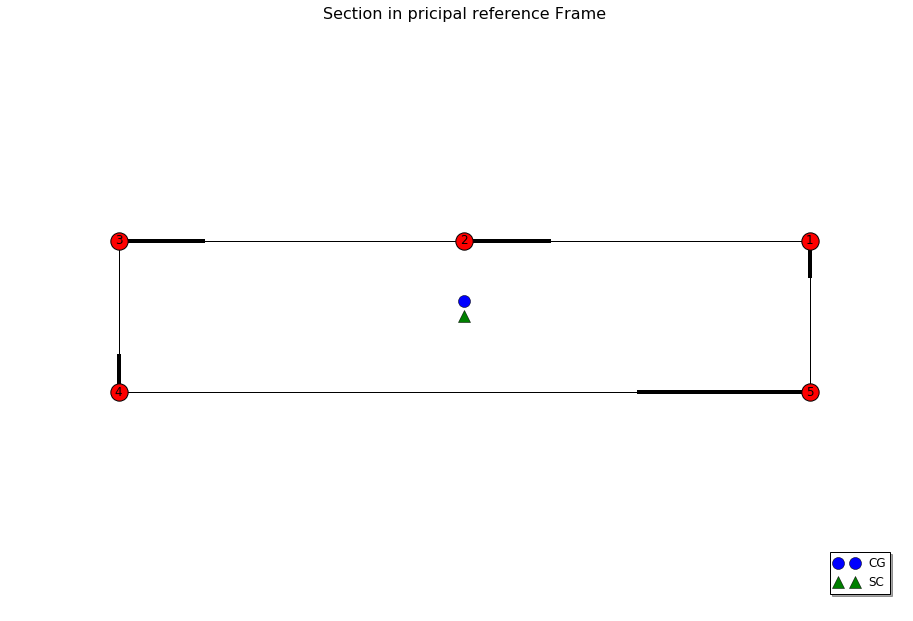

In [12]:
x_ct, y_ct = S1.ct.subs(datav)

plt.figure(figsize=(12,8),dpi=300)
nx.draw(S1.g,with_labels=True, pos=positions)
plt.plot([0],[0],'o',ms=12,label='CG')
plt.plot([x_ct],[y_ct],'^',ms=12, label='SC')
#plt.text(0,0, 'CG', fontsize=24)
#plt.text(x_ct,y_ct, 'SC', fontsize=24)
plt.legend(loc='lower right', shadow=True)
plt.axis('equal')
plt.title("Section in pricipal reference Frame",fontsize=16);

Compute **L** matrix: with 5 nodes we expect 2 **dofs**, one with _symmetric load_ and one with _antisymmetric load_

In [14]:
S1.compute_L()

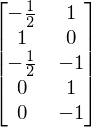

In [15]:
S1.L

Compute **H** matrix

In [16]:
S1.compute_H()

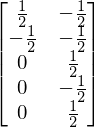

In [17]:
S1.H

Compute $\tilde{K}$ and $\tilde{M}$ as:

$$\tilde{K} = L^T \cdot \left[ \frac{A}{A_0} \right] \cdot L$$
$$\tilde{M} = H^T \cdot \left[ \frac{l}{l_0}\frac{t_0}{t} \right] \cdot L$$

In [18]:
S1.compute_KM(A,h,t)

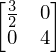

In [19]:
S1.Ktilde

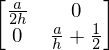

In [20]:
S1.Mtilde

Compute **eigenvalues** and **eigenvectors** as:

$$\left| \mathbf{I} \cdot \beta^2 - \mathbf{\tilde{K}}^{-1} \cdot \mathbf{\tilde{M}} \right| = 0$$

We substitute some numerical values to simplify the expressions

In [21]:
sol_data = (S1.Ktilde.inv()*(S1.Mtilde.subs(datav))).eigenvects()

**Eigenvalues** correspond to $\beta^2$

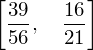

In [22]:
β2 = [sol[0] for sol in sol_data]
β2

**Eigenvectors** are orthogonal as expected

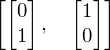

In [23]:
X = [sol[2][0] for sol in sol_data]
X

From $\beta_i^2$ we compute:
$$\lambda_i = \sqrt{\frac{E A_0 l_0}{G t_0} \beta_i^2}$$

substuting numerical values

In [24]:
λ = [sympy.N(sympy.sqrt(E*A*h/(G*t)*βi).subs(datav)) for βi in β2]
λ